<a href="https://colab.research.google.com/github/odeypatrick/Flutter_project_API/blob/main/genome_classification_using_neural_networks2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Modules

The first 4 lines will make your code reproducible.

In [1]:
#To make the code reproducible
import numpy as np
np.random.seed(0)
from tensorflow.random import set_seed
set_seed(0)

#Libraries to be used 
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline
print('NetworkX version: {}'.format(nx.__version__))


NetworkX version: 2.6.3


# Loading Data

Reading the dataset 

In [5]:
train_df = pd.read_csv('data_set_ALL_AML_train.csv')
test_df = pd.read_csv('data_set_ALL_AML_independent.csv')
train_df.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [6]:
test_df.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


In [8]:
actual_df = pd.read_csv('actual.csv')
actual_df.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [9]:
print(f"Number of value counts \n{actual_df['cancer'].value_counts()}")
print(f"The shape of the actual {actual_df.shape}")

Number of value counts 
ALL    47
AML    25
Name: cancer, dtype: int64
The shape of the actual (72, 2)


<b>Checking The number of labels to check for imbalance(imbalance that is when count of a class is larger than more than half of the other label class data set but from our dataset it shows there is no much diffrence between our labels </b>


<b> Recoding labels to numeric since most machine learning models works only with numeric data and not categorical there is need for our labels to be recoded back to numerics</b>

In [10]:
y = actual_df.replace({'ALL':0, 'AML':1})
y = y.set_index('patient')
labels = ['ALL', 'AML']

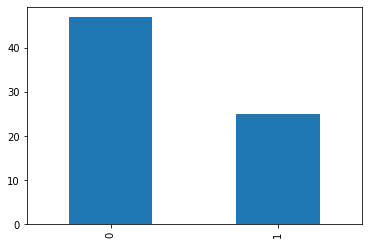

In [11]:
#visualising the labels for clarity of inbalance cause imbalance data may bias the predictio
y["cancer"].value_counts().plot(kind='bar', )

##Feature Engineering

In [12]:
#using ACO
class ant:
    def __init__(self, G, start = 'S', end = 'T', alpha = 1, beta = 1):
        self.G = G
        self.current_city, self.target_city = start, end
        self.alpha, self.beta = alpha, beta
        self.route = {self.current_city : 0}
        self.L = 0
        
        
        def move(self):
            if self.current_city == self.target_city: return
            #Dont visit an already followed path
            possible_edges = [e for e in G.edges([self.current_city]) if e[1] not in self.route]
            possible_cities = [e[1] for e in possible_edges]
            
            distances = np.array([G.edges[e]['weight'] for e in possible_edges])
            pheromons = np.array([G.edges[e]['pheromone'] for e in possible_edges])
            
            preferences = pheromons**self.alpha/distance**self.beta
            probabilities = preferences/preferences.sum()
            
            new_city = np.random.choice(a = possible_cities, size=1,
                                       p =probabilities)[0]
            self.L += self.G.edges[(self.current_city, new_city)]['weight']
            self.current_city = new_city
            self.route[self.current_city] = len(self.route)
            
        def go():
            for i in range(self.G.number_of_nodes()):
                self.move()
        def get_path(self):
            inv_route = {v:k for k, v in self.route.items()}
            return [inv_route[i] for i in range(len(inv_route))]
class antcolony(ant):
    def __init__(self, G, start = 'S', end = 'T', alpha = 1, beta = 1):
        self.G, eps = G, 0.0001
        nx.set_edge_attributes(self.G, eps, 'pheromone')
        self.start, self.end = start, end
        self.alpha, self.beta = alpha, beta
        
    def evaporation(self, decay = 0.05):
        #Evaporation of pheromon
        phe = nx.get_edge_attribute(G, 'pheromone')
        new_phe = {k:v * (1 - decay) for k,v in phe.items()}
        nx.set_edge_attributes(self.G, new_phe, 'pheromone')
         
    def deposit(self, route, L, delta =1):
        for i,j in zip(route[:-1], route[1:]):
            self.G.edges[(i, j)]['pheromone'] += delta/L
            
    def run(self, number_of_ants =10, time=20):
        #in each time step
        for t in range(time):
            #K ants exist in the colony
            self.colony = [ant(self.G, self.start, self.end, self.alpha, self.beta)
                          for k in range(number_of_ants)]
            for k in range(number_of_ants): self.colony[k].go()
            for k in range(number_of_ants):
                self.deposit(route=self.colony[k].get_path(),
                            L = self.colony[k].L)
            self.evaporation()

<b> Some EDA (exploratory data analsis to know our data more) </b>

In [13]:
#checkking to see the shape of our data set
print("Shape of Training Data: ", train_df.shape)
print("Shape of Testing Data: ", test_df.shape)

Shape of Training Data:  (7129, 78)
Shape of Testing Data:  (7129, 70)


<b>The train test has 7129 rows and 78 columns
while our testing data set has also 7129 rows and 70 columns</b>

In [14]:
#some eda to check the relevance of the call columns 
train_df['call'].value_counts()

A    5003
P    1993
M     133
Name: call, dtype: int64

In [15]:
#The call column has no much of information so it wiil be looked into
train_to_keep=[col for col in train_df.columns if "call" not in col]
test_to_keep=[col for col in test_df.columns if "call" not in col]
#the train and test set we will continue exploring with


#slicing the the columns to be used from the train_df and test_df 
X_train = train_df[train_to_keep]
X_test = test_df[test_to_keep]

<b>Now we can simply transpose both training and testing dataframes so that genes become columns(features) and patients become rows.</b>

In [16]:
X_train = X_train.T
X_test = X_test.T

In [17]:
#renamig the ant 
ant_xtrain = X_train.values
ant_xtest = X_test.values

The first 2 rows are duplicated so we can remove 'Gene Description' and set 'Gene Accession Number' as the column headers.

In [18]:
#viewing the first few rows of the head dataset
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),...,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41


In [19]:
#X_train.columns = X_train.iloc[1]
#X_test.columns = X_test.iloc[1]
#removing the Gene description and Gene accession number rows after the trasponse
X_train = X_train.drop(['Gene Description', 'Gene Accession Number'])
X_test = X_test.drop(['Gene Description', 'Gene Accession Number'])

In [20]:
#reviewing the dataset once again
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [21]:
#Sorting The index of the Transpose dataset to be in order of ascending ie smallest to largest
X_train.index = X_train.index.astype(int)
X_train.sort_index(inplace=True)

X_test.index = X_test.index.astype(int)
X_test.sort_index(inplace=True)

In [22]:
print("Shape of Training data:\t", X_train.shape)
print("Shape of Testing Data:\t", X_test.shape)

Shape of Training data:	 (38, 7129)
Shape of Testing Data:	 (34, 7129)


<b>After transposing and resorting the data  we now have 38 rows in train and 34 rows in test  as oppose to the initial 7129 </b>

In [23]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


Now let's split the target labels into training and testing targets.

In [24]:
#we define the label also taking 38 rows to follow suit with  our number of X_train and X_test 
y_train = y['cancer'][:38]
y_test = y['cancer'][38:]

#y_train will consist of the first 38 rows the dataset and the y_test will consist of rows from the 38 row down to the last

### Scaling Feautures 
# Model Algorithm works well when the data to be feed into are scaled 
1. cause it makes it easier for machine learning models to learn and understand problems
# For this problem we will be using the StandardScaler sd=(x - mean(x))/ standardDeviation it literarilly converts all
# The basic concept behind the standardization function is to make data points centred about the mean of all the data points presented in a feature with a unit standard deviation. This means the mean of the data point will be zero and the standard deviation will be 1.

Note that the test set must use identical scaling to the training set.

In [25]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
count,38,38,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,38
unique,35,35,35,37,38,36,37,38,34,36,...,33,38,36,38,36,38,37,31,36,36
top,-81,-150,-1,132,-295,-558,-31,-176,34,350,...,185,511,57,389,-22,793,295,9,116,-41
freq,2,2,2,2,1,2,2,1,2,2,...,2,1,3,1,2,1,2,2,2,2


In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


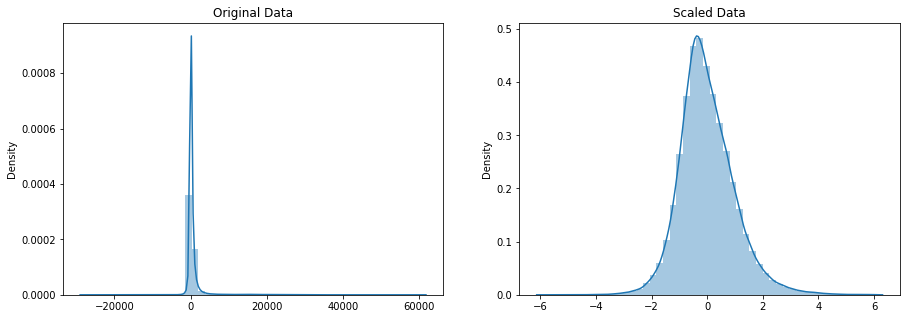

In [27]:
#lets do a distplot to check for skewness 
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.distplot(np.concatenate(X_train.values), ax=ax[0]).set_title('Original Data')
sns.distplot(np.concatenate(X_train_scaled), ax=ax[1]).set_title('Scaled Data')
plt.tight_layout
plt.show()

<b> our distribution plots shows no skewness one good use of standardization</b>

## Dimentionality reduction(PCA)

You need to apply the same PCA on training and testing sets. 
PCA to reduce the number of columns to a reasonable amount from the 7129 

In [28]:
pca = PCA(n_components = 0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(X_train_pca.shape)
print(X_test_pca.shape)

(38, 32)
(34, 32)


In [29]:
pca.explained_variance_ratio_.cumsum()

array([0.14987793, 0.26965604, 0.33566172, 0.38451094, 0.43083509,
       0.46805475, 0.50296448, 0.53586132, 0.56571468, 0.5921679 ,
       0.61726347, 0.64084201, 0.66289529, 0.68377393, 0.70319176,
       0.72212583, 0.7405972 , 0.7577301 , 0.77478241, 0.79122998,
       0.80658588, 0.82187356, 0.8364345 , 0.85074541, 0.86489756,
       0.87868324, 0.8921573 , 0.90521603, 0.9182476 , 0.93073848,
       0.9423376 , 0.95350569])

our dimension was reduce to 32 from the 7129 we got after the applying dimensionality reduction method cause out of all the features the first 32 columns gives the cummulative sum of 95

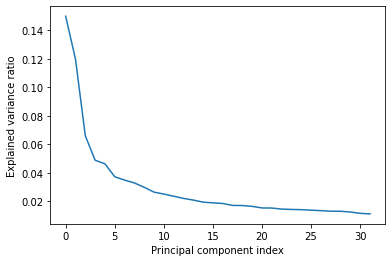

In [30]:
var = pca.explained_variance_ratio_
plt.plot(var)
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()

<b>our elbow is at an index vallue of four from our chart that is 3 components give more optimal contribution out of the 32 screened features .<b>
<b> we will be keeping 3 features</b>

In [31]:
# print(len(pca.components_))
pca.explained_variance_ratio_.sum()

0.9535056857795444

95% of variance is explained by 32 principal components. We can't plot something in 32 dimensions, so let's just see what the PCA looks like when we just pick the top three compoments.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


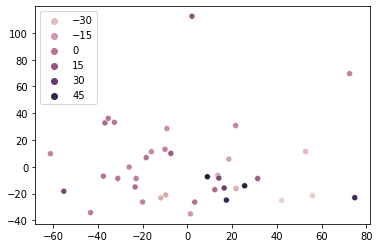

In [32]:
#we are going to use only 3 of the features since they show significant contribution out the rest 30 features
pca3 = PCA(n_components = 3).fit_transform(X_train_scaled)
colors = np.where(y_train==0, 'red', 'blue')
plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
#ax = Axes3D(fig, elev=-150, azim=110,)
sns.scatterplot(pca3[:, 0], pca3[:, 1], pca3[:, 2])
plt.show()

## Neural Network
# using deep learning neural network to train the model 

In [33]:
NN_model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=X_train_pca[1].shape),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

#sincce it is a classification task as for the standard of deeplearning models the last layer should be a sigmoid activation function which output probability that is 0 & 1

In [34]:
NN_model.compile(
    #the cross-entropy loss is the metric to the model with its compile method
    loss='binary_crossentropy',
    optimizer='adam',
    #the binary accuracy since we are dealing with two classification problem
    metrics=['binary_accuracy']
)

In [35]:
#the early stopping is handy for epochs that are likely to take time compiling
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.005,
    restore_best_weights=True,
)

<b> fitting the model</b>

In [36]:
train_history = NN_model.fit(
    X_train_pca, y_train,
    validation_data=(X_test_pca, y_test),
    batch_size = 8,
    epochs = 200,
    callbacks=[early_stopping]
)

Epoch 1/200
5/5 [==============================] - 2s 100ms/step - loss: 1.7310 - binary_accuracy: 0.7368 - val_loss: 1.1281 - val_binary_accuracy: 0.7059
Epoch 2/200
5/5 [==============================] - 0s 20ms/step - loss: 1.2294 - binary_accuracy: 0.7632 - val_loss: 0.9606 - val_binary_accuracy: 0.7353
Epoch 3/200
5/5 [==============================] - 0s 35ms/step - loss: 0.8397 - binary_accuracy: 0.8158 - val_loss: 0.8433 - val_binary_accuracy: 0.7353
Epoch 4/200
5/5 [==============================] - 0s 16ms/step - loss: 0.5935 - binary_accuracy: 0.8684 - val_loss: 0.7554 - val_binary_accuracy: 0.7647
Epoch 5/200
5/5 [==============================] - 0s 34ms/step - loss: 0.3975 - binary_accuracy: 0.8947 - val_loss: 0.6962 - val_binary_accuracy: 0.7941
Epoch 6/200
5/5 [==============================] - 0s 25ms/step - loss: 0.2753 - binary_accuracy: 0.9211 - val_loss: 0.6532 - val_binary_accuracy: 0.8235
Epoch 7/200
5/5 [==============================] - 0s 16ms/step - loss: 0.1

In [40]:
pred = NN_model.predict(X_test_pca)
print('Neural Network accuracy: ', (accuracy_score(y_test, pred.round()), 3))

Neural Network accuracy:  (0.8529411764705882, 3)


<b>After the training we got a pretty good accuracy of 85% not bad</b> 

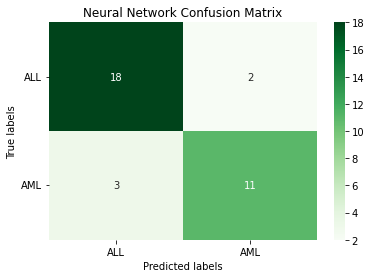

In [42]:
#plotting a confusion matrix to see how good our predictions does on a the datasets
cm_nn = confusion_matrix(y_test, pred.round())

ax = plt.subplot()
sns.heatmap(cm_nn, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Neural Network Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

<b>comaring the prediction perforance of our predicted result</b>
1. True Negatve = 18 : That the model predicted 18 instances that are 0 and truy are 
2. False positive = 2: that is our model predicted only 2 instance to be  1 which is not
3. False negative = 3 : that is our model predcited only 3 instances to be 0 which is not 
4. True positive = 11 : that is the model prediceted 11 instances to be 1 and they are truly 1.

considring the low values in the false positive and false negative it clearly indicates that our model will not uderfit to unknown datasets.

In [43]:
ant_train = train_df.copy() 
ant_test = train_df.copy()

tryin to optimize the dataset using antcolony optimaization

##trying out the ant colony optimaization the aim is to see how we can feed a column to it just like the pca does to give us optimal result as regard to the best route the ant pheromone will be more concentrated towrds to give the best optimal features .


In [46]:
#using ACO
class ant():
    def __init__(self, G, start = 'S', end = 'T', alpha = 1, beta = 1):
        self.G = G
        self.current_city, self.target_city = start, end
        self.alpha, self.beta = alpha, beta
        self.route = {self.current_city : 0}
        self.L = 0
        
        
        def move(self):
            if self.current_city == self.target_city: return
            #Dont visit an already followed path
            possible_edges = [e for e in G.edges([self.current_city]) if e[1] not in self.route]
            possible_cities = [e[1] for e in possible_edges]
            
            distances = np.array([G.edges[e]['weight'] for e in possible_edges])
            pheromons = np.array([G.edges[e]['pheromone'] for e in possible_edges])
            
            preferences = pheromons**self.alpha/distance**self.beta
            probabilities = preferences/preferences.sum()
            
            new_city = np.random.choice(a = possible_cities, size=1,
                                       p =probabilities)[0]
            self.L += self.G.edges[(self.current_city, new_city)]['weight']
            self.current_city = new_city
            self.route[self.current_city] = len(self.route)
            
        def go():
            for i in range(self.G.number_of_nodes()):
                self.move()
        def get_path(self):
            inv_route = {v:k for k, v in self.route.items()}
            return [inv_route[i] for i in range(len(inv_route))]
class antcolony():
    def __init__(self, G, start = 'S', end = 'T', alpha = 1, beta = 1):
        self.G, eps = G, 0.0001
        nx.set_edge_attributes(self.G, eps, 'pheromone')
        self.start, self.end = start, end
        self.alpha, self.beta = alpha, beta
        
    def evaporation(self, decay = 0.05):
        #Evaporation of pheromon
        phe = nx.get_edge_attributes(G, 'pheromone')
        new_phe = {k:v * (1 - decay) for k,v in phe.items()}
        nx.set_edge_attributes(self.G, new_phe, 'pheromone')
         
    def deposit(self, route, L, delta =1):
        for i,j in zip(route[:-1], route[1:]):
            self.G.edges[(i, j)]['pheromone'] += delta/L
            
    def run(self, number_of_ants =10, time=20):
        #in each time step
        for t in range(time):
            #K ants exist in the colony
            self.colony = [ant(self.G, self.start, self.end, self.alpha, self.beta)
                          for k in range(number_of_ants)]
            #for k in range(number_of_ants): self.colony[k].go()
            #for k in range(number_of_ants):
                #self.deposit(route=self.colony[k].get_path(),
                            #L = self.colony[k].L)
            self.evaporation()

In [47]:
edge_list = [('S', 'A', 1), ('A', 'T', 1), ('S', 'B', 10), ('B', 'T', 10)]
G = nx.Graph()
G.add_weighted_edges_from(edge_list)

swarm = antcolony(G, start='S', end='T', alpha=1, beta = 1)
swarm.run(number_of_ants = 10, time = 2)